In [ ]:
# @title Imports

import pandas as pd
import numpy as np

from collections import Counter
from sklearn.datasets import fetch_openml
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from plotnine import *

In [ ]:
# @title Get data

pima = fetch_openml('diabetes', parser='auto', version=1)
X = pima['data'][['age', 'pedi']]

le = LabelEncoder()
le.fit(pima['target'])
y = le.transform(pima['target'])
y = pima['target']

print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({'tested_negative': 500, 'tested_positive': 268})


In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
# @title Downsample with CNN using k=3

cnn = CondensedNearestNeighbour(random_state=8675309, n_neighbors=3)
X_scaled_cnn, y_cnn = cnn.fit_resample(X_scaled, y)

print('Resampled dataset shape %s' % Counter(y_cnn))

Resampled dataset shape Counter({'tested_positive': 268, 'tested_negative': 210})


In [ ]:
# @title Downsample with TomekLinks

tl = TomekLinks()
X_scaled_tl, y_tl = tl.fit_resample(X_scaled, y)

print('Resampled dataset shape %s' % Counter(y_tl))

Resampled dataset shape Counter({'tested_negative': 411, 'tested_positive': 268})


In [ ]:
# @title Downsample with TomekLinks

enn = EditedNearestNeighbours()
X_scaled_enn, y_enn = enn.fit_resample(X_scaled, y)

print('Resampled dataset shape %s' % Counter(y_enn))

Resampled dataset shape Counter({'tested_positive': 268, 'tested_negative': 203})


In [ ]:
clf = LogisticRegression()

fit = clf.fit(X_scaled, y)
fit_cnn = clf.fit(X_scaled_cnn, y_cnn)
fit_tl = clf.fit(X_scaled_tl, y_tl)
fit_enn = clf.fit(X_scaled_enn, y_enn)

In [ ]:
def create_data(X: np.array,
                y: np.array,
                columns: list,
                label: str,
                fit: LogisticRegression,
                scaler: StandardScaler = scaler) -> pd.DataFrame:
  data = (
      pd.DataFrame(scaler.inverse_transform(X), columns=columns)
        .assign(actual=y)
        .assign(predicted=fit.predict_proba(X)[:, 1])
        .assign(sampler=label)
  )
  return data

data = create_data(
    X_scaled, y, X.columns, label='None', fit=fit, scaler=scaler)
data_cnn = create_data(
    X_scaled_cnn, y_cnn, X.columns, label='CNN', fit=fit_cnn, scaler=scaler)
data_tl = create_data(
    X_scaled_tl, y_tl, X.columns, label='TomekLinks', fit=fit_tl, scaler=scaler)
data_enn = create_data(
    X_scaled_enn, y_enn, X.columns, label='ENN', fit=fit_enn,
    scaler=scaler)

all_data=pd.concat([data, data_cnn, data_tl, data_enn])
all_data['sampler'] = pd.Categorical(
    all_data['sampler'], categories=['None', 'CNN', 'TomekLinks', 'ENN'])

In [ ]:
def build_mesh(x: np.array,
               fit: LogisticRegression,
               scaler: StandardScaler,
               n_steps: int=25,
               xlim: list=None,
               ylim: list=None,
               sampler: str=None) -> pd.DataFrame:
  xval = x[:, 0]
  yval = x[:, 1]

  if xlim is None:
    x_min, x_max = xval.min(), xval.max()
  else:
    x_min, x_max = xlim[0], xlim[1]

  if ylim is None:
    y_min, y_max = yval.min(), yval.max()
  else:
    y_min, y_max = ylim[0], ylim[1]

  step_x = (x_max - x_min) / n_steps
  step_y = (y_max - y_min) / n_steps
  xx, yy = np.meshgrid(
      np.arange(x_min, x_max + step_x, step_x),
      np.arange(y_min, y_max + step_y, step_y)
  )

  xy = np.c_[xx.ravel(), yy.ravel()]
  Z = fit.predict(xy)
  xy_inv = scaler.inverse_transform(xy)
  step_x_inv = (xy_inv[:, 0].max() - xy_inv[:, 0].min()) / n_steps
  step_y_inv = (xy_inv[:, 1].max() - xy_inv[:, 1].min()) / n_steps
  regions = pd.DataFrame({
      'x': xy_inv[:, 0],
      'y': xy_inv[:, 1],
      'Z': Z
  })
  regions['Z'] = regions['Z'].astype('category')
  regions['step_x'] = step_x_inv
  regions['step_y'] = step_y_inv

  if sampler is None:
    regions = regions.assign(sampler='None')
  else:
    regions = regions.assign(sampler=sampler)
  return regions

xval = X_scaled[:, 0]
yval = X_scaled[:, 1]
xlim = [xval.min(), xval.max()]
ylim = [yval.min(), yval.max()]

regions = build_mesh(X_scaled, fit, scaler, xlim=xlim, ylim=ylim, sampler='None')
regions_cnn = build_mesh(X_scaled_cnn, fit_cnn, scaler, xlim=xlim, ylim=ylim, sampler='CNN')
regions_tl = build_mesh(X_scaled_tl, fit_tl, scaler, xlim=xlim, ylim=ylim, sampler='TomekLinks')
regions_enn = build_mesh(X_scaled_enn, fit_enn, scaler, xlim=xlim, ylim=ylim, sampler='ENN')

all_regions=pd.concat([regions, regions_cnn, regions_tl, regions_enn])
all_regions['sampler'] = pd.Categorical(
    all_regions['sampler'], categories=['None', 'CNN', 'TomekLinks', 'ENN'])

In [ ]:
sample_size_labels = (
    all_data
      .sampler
      .value_counts()
      .reset_index()
      .rename(columns={'sampler': 'n', 'index': 'sampler'})
      .pipe(lambda p: p.assign(
          label = ['n = ' + str(x) for x in p.n]))
      .assign(x = all_regions.x.max(), y = all_regions.y.max())
)

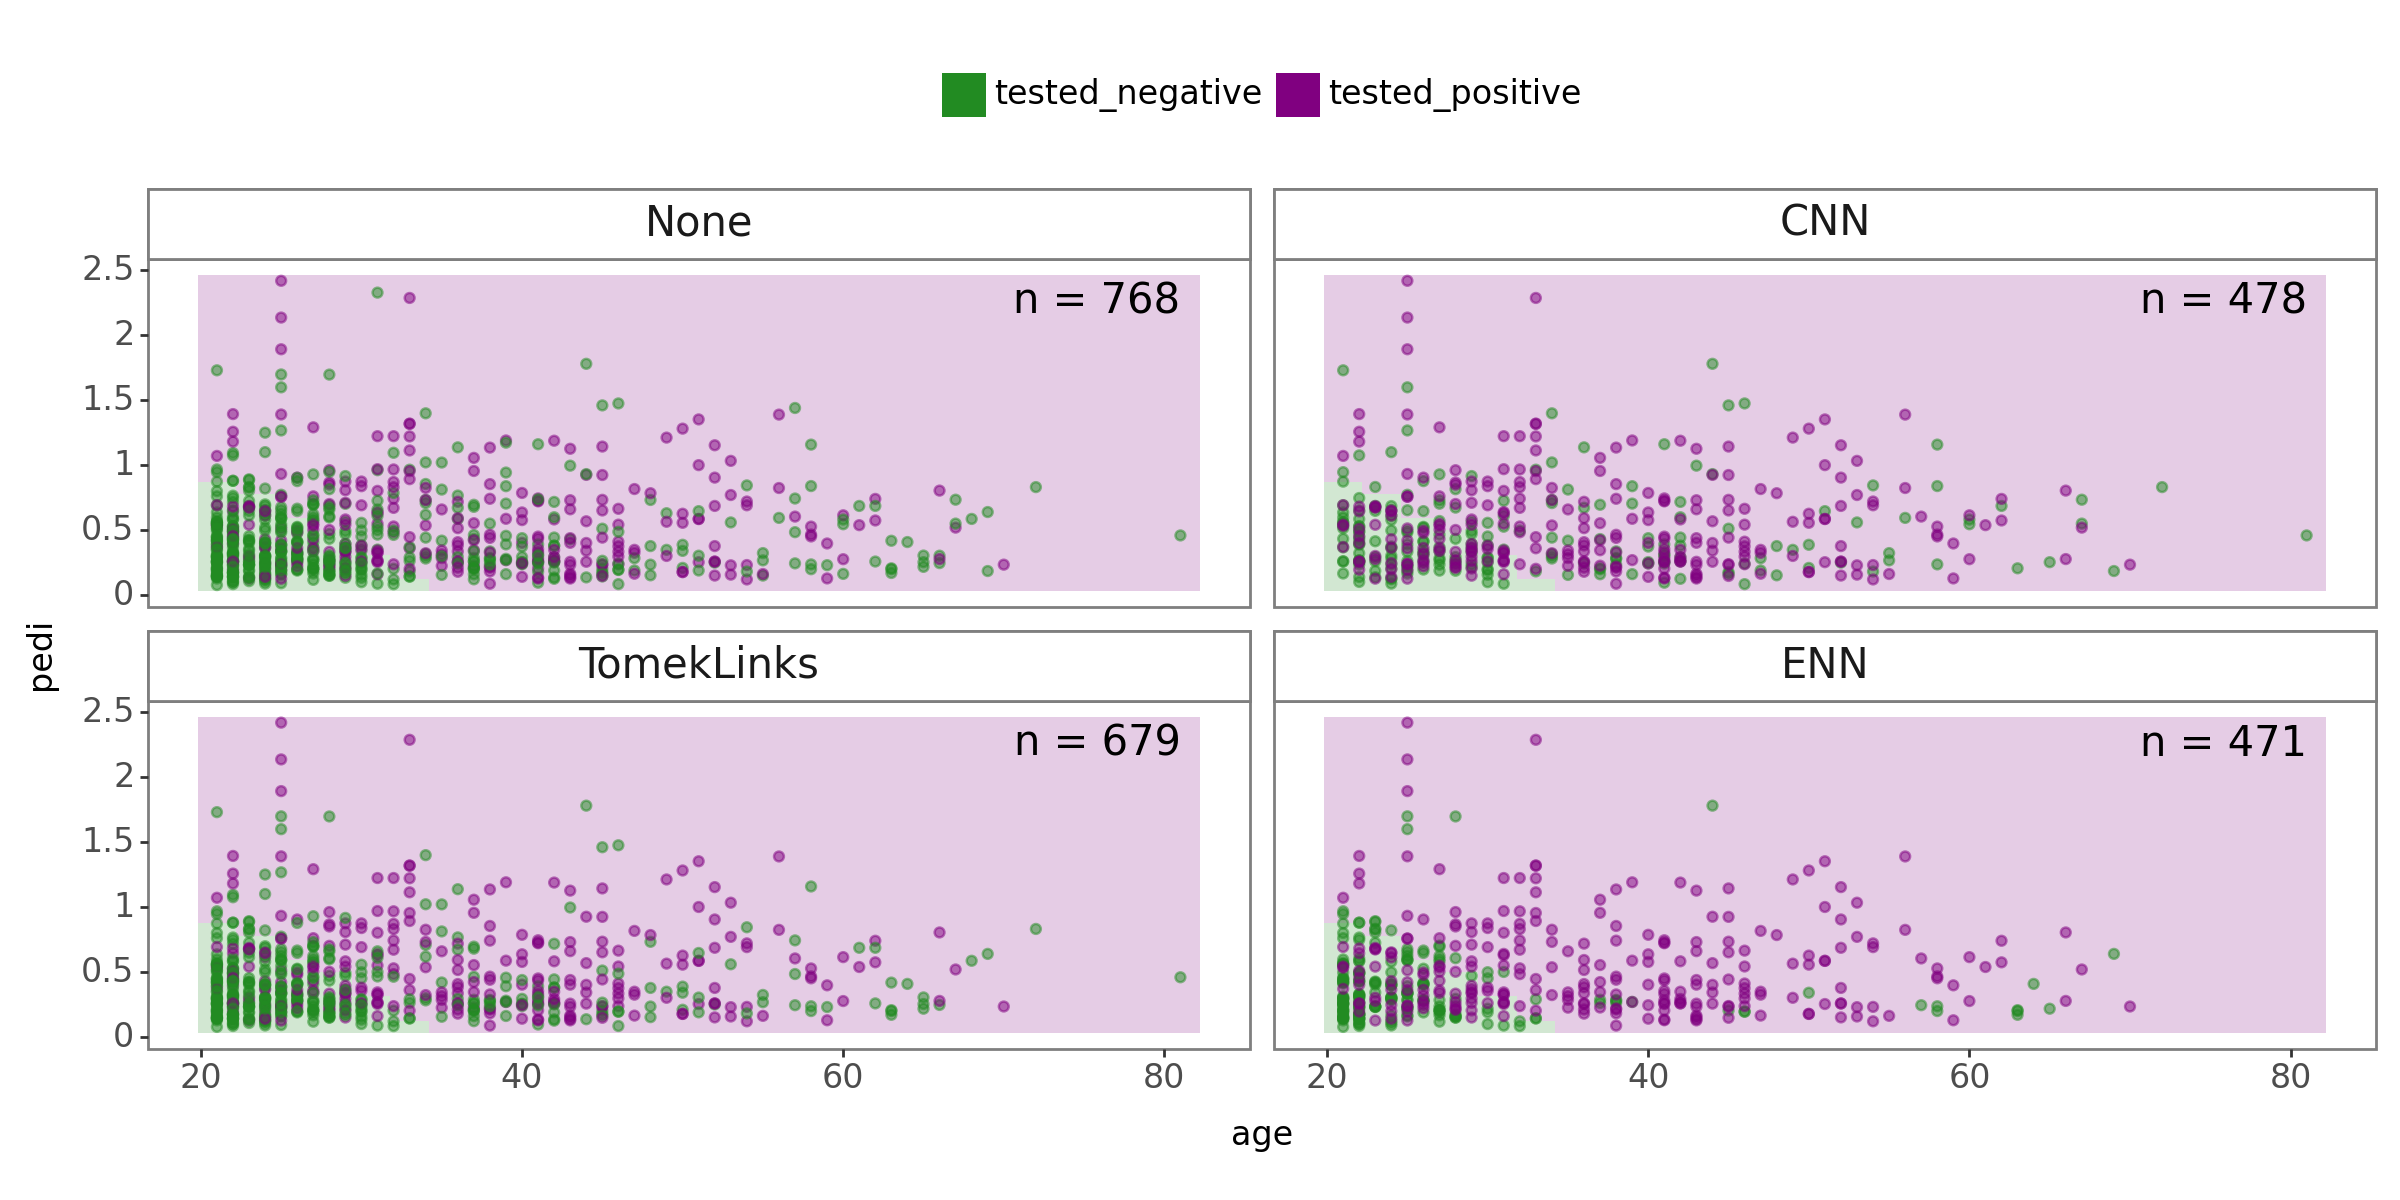

<Figure Size: (1200 x 600)>

In [ ]:
(
  ggplot() +
    geom_tile(aes(x='x', y='y', fill='Z', width='step_x', height='step_y'),
              data=all_regions, alpha=0.2) +
    geom_point(aes(x='age', y='pedi', color='actual'),
               data=all_data, show_legend=False, alpha=0.5) +
    geom_text(aes(x='x', y='y', label='label'),
              data=sample_size_labels, ha='right', va='top', size = 15) +
    theme_bw() +
    scale_fill_manual(values=['forestgreen', 'purple']) +
    scale_color_manual(values=['forestgreen', 'purple']) +
    labs(x='age', y='pedi') +
    facet_wrap('~sampler') +
    guides(fill=guide_legend(override_aes={'alpha': 1.0})) +
    theme(legend_title=element_blank(),
          legend_position='top',
          panel_grid_major=element_blank(),
          panel_grid_minor=element_blank(),
          figure_size=[12, 6],
          strip_background=element_rect(fill='white'),
          axis_text=element_text(size=12),
          axis_title=element_text(size=12),
          legend_text=element_text(size=12),
          strip_text=element_text(size=15))
)